In [1]:
import sys

sys.path.append('/home/max/myrepos/vlstm_cuda/')

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
import triton
import triton.language as tl
import math

In [2]:
triton.runtime.driver.active.get_current_target()

GPUTarget(backend='cuda', arch=89, warp_size=32)

In [3]:
from src_triton.mlstm_parallel_fwbw_v0.mlstm_bw2 import mlstm_bw
from src_triton.mlstm_parallel_fwbw_v0.torch_impl import vlstm_parallel_w_groupnorm_torch_bw as mlstm_bw_torch
from plot_utils import plot_numerical_diffs_single

In [4]:
list(range(0,0*8,4))

[]

In [5]:
S = 128 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 128 # dim per head

DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

BLOCK_Q = 16
BLOCK_KV = 16

In [6]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# qs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# # vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 100.
# # vs = torch.zeros((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# vs[:,:,1,0] = 7.
# qs[:,:,1,0] = 1.

# vs[:,:,1,16] = 8.
# qs[:,:,1,16] = 1.
# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S) / 10.
# igs = torch.zeros((B, NH, S), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S), device=DEVICE, dtype=DTYPE)
# fgs = torch.ones((B, NH, S), device=DEVICE, dtype=DTYPE) *0.9 - torch.randn((B, NH, S), device=DEVICE, dtype=DTYPE) / 100.
fgs = torch.randn((B, NH, S), device=DEVICE, dtype=DTYPE)

dH = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vecN = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
vecM = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

In [7]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dH_half = dH.to(dtype=dtype_fp16)
vecN_half = vecN.to(dtype=dtype_fp16)
vecM_half = vecM.to(dtype=dtype_fp16)

In [8]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dH_bf16 = dH.to(dtype=dtype_bf16)
vecN_bf16 = vecN.to(dtype=dtype_bf16)
vecM_bf16 = vecM.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [9]:
dQ_pt_p, dK_pt_p, dV_pt_p, dI_pt_p, dF_pt_p = mlstm_bw_torch(matDeltaHtilde=dH, matQ=qs, matK=ks, matV=vs, vecN=vecN, vecM=vecM, vecI=igs.unsqueeze(-1), vecF=fgs.unsqueeze(-1))

In [10]:
dQ_pt_p_half, dK_pt_p_half, dV_pt_p_half, dI_pt_p_half, dF_pt_p_half = mlstm_bw_torch(
    matDeltaHtilde=dH_half,
    matQ=qs_half,
    matK=ks_half,
    matV=vs_half,
    vecN=vecN_half,
    vecM=vecM_half,
    vecI=igs_half.unsqueeze(-1),
    vecF=fgs_half.unsqueeze(-1),
)

In [11]:
dQ_pt_p_bf16, dK_pt_p_bf16, dV_pt_p_bf16, dI_pt_p_bf16, dF_pt_p_bf16 = mlstm_bw_torch(
    matDeltaHtilde=dH_bf16,
    matQ=qs_bf16,
    matK=ks_bf16,
    matV=vs_bf16,
    vecN=vecN_bf16,
    vecM=vecM_bf16,
    vecI=igs_bf16.unsqueeze(-1),
    vecF=fgs_bf16.unsqueeze(-1),
)

In [12]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"dQ match: {torch.allclose(dQ_pt_p_half.float(), dQ_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dQ_pt_p_half - dQ_pt_p))}")
print(f"dK match: {torch.allclose(dK_pt_p_half.float(), dK_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dK_pt_p_half - dK_pt_p))}")
print(f"dV match: {torch.allclose(dV_pt_p_half.float(), dV_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dV_pt_p_half - dV_pt_p))}")
print(f"dI match: {torch.allclose(dI_pt_p_half.float(), dI_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dI_pt_p_half - dI_pt_p))}")
print(f"dF match: {torch.allclose(dF_pt_p_half.float(), dF_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dF_pt_p_half - dF_pt_p))}")

print(f"====== Full -> bfloat16 ======")
print(f"dQ match: {torch.allclose(dQ_pt_p_bf16.float(), dQ_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dQ_pt_p_bf16 - dQ_pt_p))}")
print(f"dK match: {torch.allclose(dK_pt_p_bf16.float(), dK_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dK_pt_p_bf16 - dK_pt_p))}")
print(f"dV match: {torch.allclose(dV_pt_p_bf16.float(), dV_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dV_pt_p_bf16 - dV_pt_p))}")
print(f"dI match: {torch.allclose(dI_pt_p_bf16.float(), dI_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dI_pt_p_bf16 - dI_pt_p))}")
print(f"dF match: {torch.allclose(dF_pt_p_bf16.float(), dF_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dF_pt_p_bf16 - dF_pt_p))}")

====== Full -> Half ======
dQ match: False, max diff: 3.68170166015625
dK match: False, max diff: 3.2099151611328125
dV match: False, max diff: 4.892478942871094
dI match: False, max diff: 15.62274169921875
dF match: False, max diff: 4.695343017578125
====== Full -> bfloat16 ======
dQ match: False, max diff: 104.42022705078125
dK match: False, max diff: 85.4869384765625
dV match: False, max diff: 33.46998596191406
dI match: False, max diff: 144.88189697265625
dF match: False, max diff: 120.44534301757812


### compare errors triton vs pytorch

In [13]:
dQ_tr_p_half, dK_tr_p_half, dV_tr_p_half, dI_tr_p_half, dF_tr_p_half = mlstm_bw(
    matDeltaHtilde=dH_half,
    matQ=qs_half,
    matK=ks_half,
    matV=vs_half,
    vecN=vecN_half.squeeze(-1),
    vecM=vecM_half.squeeze(-1),
    vecI=igs_half,
    vecF=fgs_half,
    # BLOCK_Q=BLOCK_Q,
    # BLOCK_KV=BLOCK_KV,
)

In [14]:
torch.abs(dI_tr_p_half - dI_pt_p.squeeze(-1))

tensor([[[1.9921e-01, 9.6152e-01, 5.5138e-02, 2.4666e-02, 3.7775e-03, 1.0293e-03, 4.5528e-03, 1.1790e-01, 1.7543e-03, 3.3501e-02, 2.5425e-03, 3.5028e-03, 9.4040e-01, 2.2786e-03, 2.3499e-01,
          4.0662e-01, 7.7753e-03, 5.3787e-02, 1.6090e-02, 3.2906e-01, 1.8530e-02, 1.0210e+00, 8.0311e-04, 5.1983e-02, 5.0272e-02, 7.8339e-02, 5.8937e-02, 1.4543e-02, 1.2091e-02, 7.4482e-03,
          1.5991e-02, 1.2289e-02, 1.4261e-02, 3.8025e-04, 6.0709e-03, 3.2303e-02, 1.3855e-02, 1.5155e-01, 1.7814e-02, 1.4954e-03, 9.8648e-03, 2.0746e-01, 4.6010e-03, 4.8623e-01, 1.1784e-01,
          2.0384e-01, 3.2532e-01, 2.6196e-01, 5.1983e-02, 7.6253e-01, 7.8366e-02, 4.6527e-02, 1.6542e-01, 8.5388e-02, 2.2822e-01, 8.6758e-01, 3.7868e-01, 1.1889e+00, 1.6516e-01, 5.6390e-02,
          1.2054e-03, 3.4561e-03, 3.2563e-02, 2.4873e-01, 2.6967e-01, 1.9190e-01, 3.2982e-02, 3.2938e-01, 4.4151e-01, 5.6839e-04, 1.8819e+00, 4.6387e-01, 1.3369e+00, 1.9880e-02, 2.0891e-01,
          2.3610e-01, 1.8961e-01, 2.9889e-01, 2.31

In [15]:
torch.abs(dF_tr_p_half - dF_pt_p.squeeze(-1))

tensor([[[2.4162e+02, 2.2767e+02, 3.9871e+01, 2.2614e+01, 1.6515e+01, 1.7341e+01, 5.6565e+00, 5.0256e-02, 1.4620e+01, 2.7321e+01, 1.0001e+01, 8.7813e+00, 2.6933e+01, 2.1987e+01, 2.2879e+01,
          1.8766e+01, 1.4623e+02, 1.3185e+02, 2.1302e+02, 8.4112e+01, 2.2314e+02, 1.6765e+02, 6.3366e+01, 3.3567e+00, 9.5656e+00, 1.1397e+01, 8.4327e+00, 3.3485e+00, 6.4431e-01, 1.1240e+01,
          2.1924e+01, 7.9323e+01, 3.8765e+01, 2.2840e+01, 8.7636e+01, 2.0677e+01, 1.0972e+01, 3.8528e+01, 8.3096e+01, 1.1179e+02, 1.1446e+02, 2.0952e+02, 1.2835e+02, 2.3794e+02, 1.8216e+02,
          1.3681e+02, 1.2670e+02, 2.4985e+02, 3.8448e+02, 1.2962e+02, 9.9956e+01, 1.8050e+02, 2.5261e+02, 2.2716e+02, 1.0061e+02, 1.1135e+02, 9.9514e+01, 3.3528e+01, 1.0867e+02, 3.8368e+02,
          8.9570e+01, 7.9558e+01, 1.3369e+02, 1.1735e+02, 6.4747e+01, 7.8490e+01, 4.3559e+01, 2.6172e+01, 4.0705e+02, 1.9396e+02, 2.7665e+02, 8.4773e+01, 1.8877e+02, 1.4538e+03, 1.0047e+03,
          1.1886e+03, 5.7507e+02, 1.8722e+02, 5.67

In [16]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full(pt) -> Half(tr) ======")
print(f"dQ match: {torch.allclose(dQ_tr_p_half.float(), dQ_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dQ_tr_p_half - dQ_pt_p))}")
print(f"dK match: {torch.allclose(dK_tr_p_half.float(), dK_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dK_tr_p_half - dK_pt_p))}")
print(f"dV match: {torch.allclose(dV_tr_p_half.float(), dV_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dV_tr_p_half - dV_pt_p))}")
print(f"dI match: {torch.allclose(dI_tr_p_half.float(), dI_pt_p.squeeze(-1), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dI_tr_p_half - dI_pt_p.squeeze(-1)))}")
print(f"dF match: {torch.allclose(dF_tr_p_half.float(), dF_pt_p.squeeze(-1), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dF_tr_p_half - dF_pt_p.squeeze(-1)))}")
print(f"====== Half(pt) -> Half(tr) ======")
print(f"dQ match: {torch.allclose(dQ_tr_p_half.float(), dQ_pt_p_half.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dQ_tr_p_half - dQ_pt_p_half))}")
print(f"dK match: {torch.allclose(dK_tr_p_half.float(), dK_pt_p_half.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dK_tr_p_half - dK_pt_p_half))}")
print(f"dV match: {torch.allclose(dV_tr_p_half.float(), dV_pt_p_half.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dV_tr_p_half - dV_pt_p_half))}")
print(f"dI match: {torch.allclose(dI_tr_p_half.float(), dI_pt_p_half.squeeze(-1).float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dI_tr_p_half - dI_pt_p_half.squeeze(-1)))}")
print(f"dF match: {torch.allclose(dF_tr_p_half.float(), dF_pt_p_half.squeeze(-1).float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dF_tr_p_half - dF_pt_p_half.squeeze(-1)))}")


====== Full(pt) -> Half(tr) ======
dQ match: False, max diff: 623.173583984375
dK match: False, max diff: 3.2411651611328125
dV match: False, max diff: 4.892478942871094
dI match: False, max diff: 15.62274169921875
dF match: False, max diff: 1453.831298828125
====== Half(pt) -> Half(tr) ======
dQ match: False, max diff: 625.0
dK match: False, max diff: 0.25
dV match: False, max diff: 0.25
dI match: False, max diff: 2.0
dF match: False, max diff: 1454.0


In [17]:
dQ_tr_p_half

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

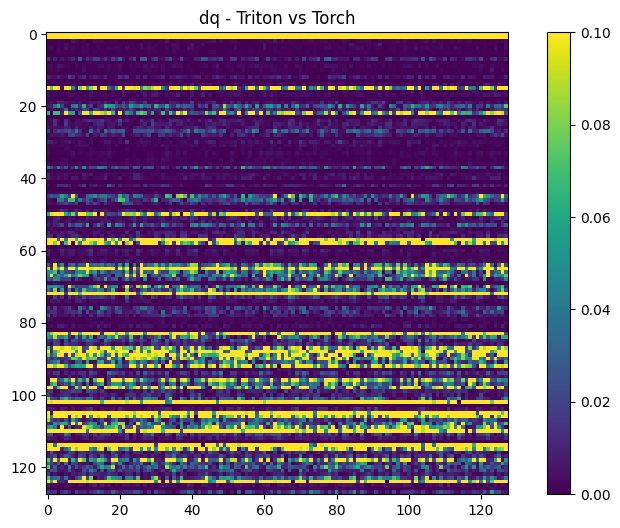

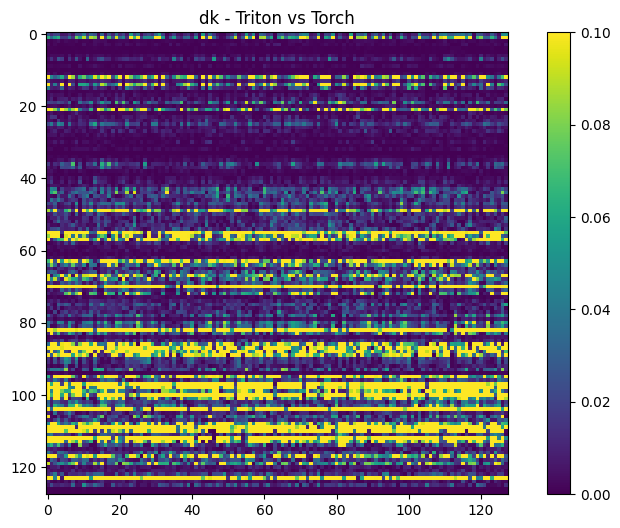

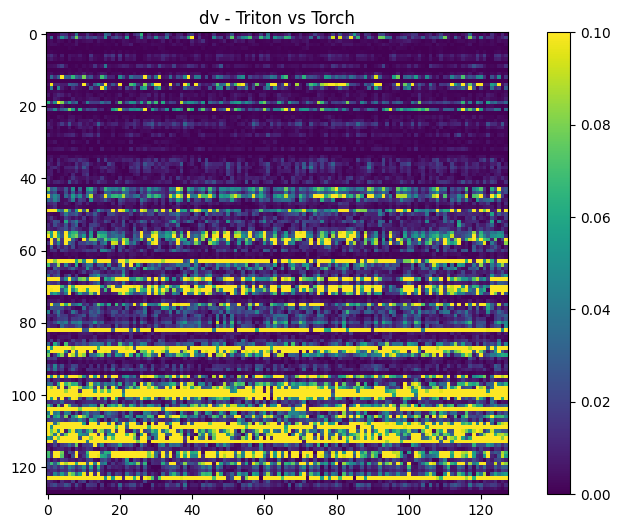

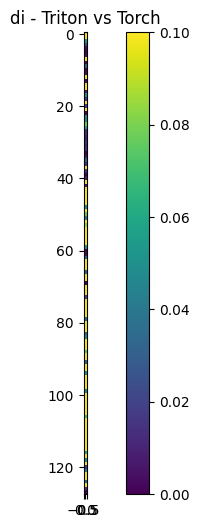

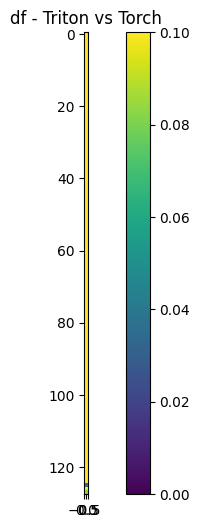

In [17]:
vmax = 0.1
fig = plot_numerical_diffs_single(dQ_tr_p_half, dQ_pt_p, "dq - Triton vs Torch", vmax=vmax)
fig = plot_numerical_diffs_single(dK_tr_p_half, dK_pt_p, "dk - Triton vs Torch", vmax=vmax)
fig = plot_numerical_diffs_single(dV_tr_p_half, dV_pt_p, "dv - Triton vs Torch", vmax=vmax)
fig = plot_numerical_diffs_single(dI_tr_p_half, dI_pt_p.squeeze(-1), "di - Triton vs Torch", vmax=vmax)
fig = plot_numerical_diffs_single(dF_tr_p_half, dF_pt_p.squeeze(-1), "df - Triton vs Torch", vmax=vmax)

## Measure Performance

In [18]:
warmup = 100
rep = 1000

BATCH, H, HEAD_DIM = 2, 8, 128
N_CTX = 1024
dtype = torch.float16
device = torch.device("cuda:0")
q = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
k = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
v = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
ig = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)
fg = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)

dH = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
vecM = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)
vecN = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)

In [19]:
mlstm_bw_pt = mlstm_bw_torch
fn = lambda: mlstm_bw_pt(dH, q, k, v, ig.unsqueeze(-1), fg.unsqueeze(-1), vecM.unsqueeze(-1), vecN.unsqueeze(-1))
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

8.751944541931152

In [20]:
mlstm_bw_pt_compile = torch.compile(mlstm_bw_torch)
fn = lambda: mlstm_bw_pt_compile(dH, q, k, v, ig.unsqueeze(-1), fg.unsqueeze(-1), vecM.unsqueeze(-1), vecN.unsqueeze(-1))
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

3.0584094524383545

In [21]:
mlstm_bw_triton = mlstm_bw
fn = lambda: mlstm_bw_triton(dH, q, k, v, ig, fg, vecM, vecN)
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

matDeltaQ_tile fp16[constexpr[16], constexpr[128]]
matDeltaQ_block_ptr pointer<<[16, 128], fp16>>[]
matDeltaQ_ptr pointer<fp16>[constexpr[16], constexpr[128]]
matDeltaQ_tile fp16[constexpr[16], constexpr[128]]
matDeltaQ_block_ptr pointer<<[16, 128], fp16>>[]
matDeltaQ_ptr pointer<fp16>[constexpr[16], constexpr[128]]


loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_bw2.py":291:11): error: operation scheduled before its operands


3.9654860496520996

In [22]:
# v1: 2.3992741107940674
# v2: 2.359653949737549 no prints all types are float16
# v3: 2.2989847660064697 no autotuning

In [23]:
start_q = 0
bq = 16
dh = 16

stride_qm = dh
stride_qk = 1


off_q = start_q + torch.arange(bq)
off_kv = torch.arange(dh)

off_q[:, None] * stride_qm + off_kv[None, :]

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15],
        [ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31],
        [ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47],
        [ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63],
        [ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79],
        [ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95],
        [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
        [112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127],
        [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143],
        [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159],
        [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175],
        [1

In [24]:
qs.stride(0), qs.stride(1), qs.stride(2), qs.stride(3)

(16384, 16384, 128, 1)